In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import string



Load the dataset

In [2]:
df = pd.read_csv('asl_landmarks_final.csv')



Filter labels: only allow A-Z

In [3]:
df = df[df['label'].isin(list(string.ascii_uppercase))]



Features and Labels

In [4]:
X = df.drop('label', axis=1).values
y = df['label'].values



Encode labels (A-Z → 0-25)

In [5]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)



Save label mapping

In [6]:
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
with open('label_map.txt', 'w') as f:
    for label, code in label_map.items():
        f.write(f"{label}:{code}\n")



Split dataset

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)



Build MLP model

In [ ]:
from tensorflow.keras.layers import LeakyReLU

model = Sequential([
    tf.keras.Input(shape=(X.shape[1],)),
    Dense(128),
    LeakyReLU(alpha=0.1),
    Dropout(0.4),
    Dense(64),
    LeakyReLU(alpha=0.1),
    Dropout(0.4),
    Dense(len(label_map), activation='softmax')
])



/opt/anaconda3/envs/asl_env/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Compile

In [10]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



Train

In [ ]:
from tensorflow.keras.callbacks import Callback
import numpy as np

class BestCombinedCheckpoint(Callback):
    def __init__(self, filepath):
        super().__init__()
        self.filepath = filepath
        self.best_acc = 0.0
        self.best_loss = np.inf

    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get('val_accuracy')
        loss = logs.get('val_loss')

        if acc > self.best_acc and loss < self.best_loss:
            print(f"\n✅ Saving new best model at epoch {epoch+1} — val_accuracy: {acc:.4f}, val_loss: {loss:.4f}")
            self.best_acc = acc
            self.best_loss = loss
            self.model.save(self.filepath)

best_combo = BestCombinedCheckpoint('best_model_combined.keras')

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=16,
    callbacks=[best_combo]
)



Epoch 1/20
  1/105 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0409
✅ Saving new best model at epoch 1 — val_accuracy: 0.9379, val_loss: 0.2267
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - accuracy: 0.9422 - loss: 0.1759 - val_accuracy: 0.9379 - val_loss: 0.2267
Epoch 2/20
  1/105 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0641
✅ Saving new best model at epoch 2 — val_accuracy: 0.9451, val_loss: 0.2000
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - accuracy: 0.9373 - loss: 0.1790 - val_accuracy: 0.9451 - val_loss: 0.2000
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - accuracy: 0.9070 - loss: 0.2459 - val_accuracy: 0.9284 - val_loss: 0.2222
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - accuracy: 0.9295 - loss: 0.1847 - val_accuracy: 0.9427 - val_loss: 0.1968
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - accuracy: 0.9310 - loss: 0.1809 - val_accuracy: 0.9308 - val_loss: 0.2231
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 575u

Save model

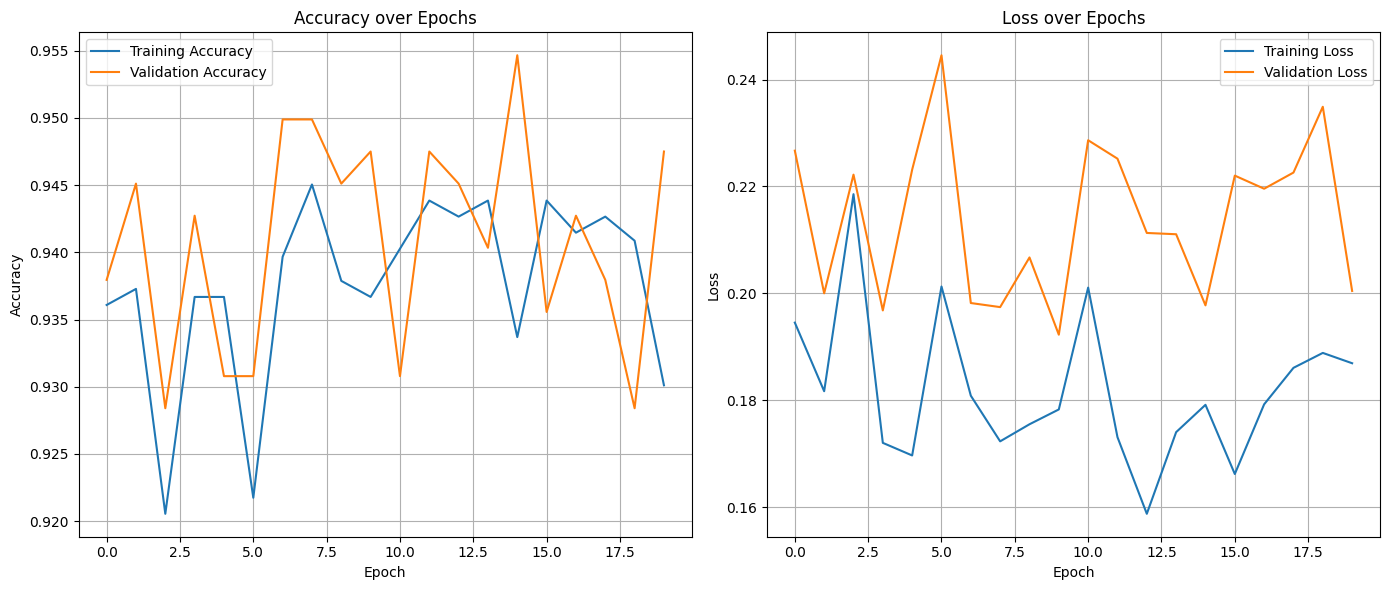

In [ ]:
import matplotlib.pyplot as plt

history_data = history.history

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history_data['accuracy'], label='Training Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_data['loss'], label='Training Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

